<a href="https://colab.research.google.com/github/Uwimbabazi-Keza/heart-disease-analysis/blob/main/Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the heart disease dataset

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

In [12]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data = pd.read_csv(url, header=None, names=columns)

data.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.438944    0.679868    3.158416  131.689769  246.693069    0.148515   
std      9.038662    0.467299    0.960126   17.599748   51.776918    0.356198   
min     29.000000    0.000000    1.000000   94.000000  126.000000    0.000000   
25%     48.000000    0.000000    3.000000  120.000000  211.000000    0.000000   
50%     56.000000    1.000000    3.000000  130.000000  241.000000    0.000000   
75%     61.000000    1.000000    4.000000  140.000000  275.000000    0.000000   
max     77.000000    1.000000    4.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope      target  
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000  
mean     0.990099  149.607261    0.326733    1.039604    1.600660    0.937294  
std      0.994971   22.875003 

<Axes: xlabel='target'>

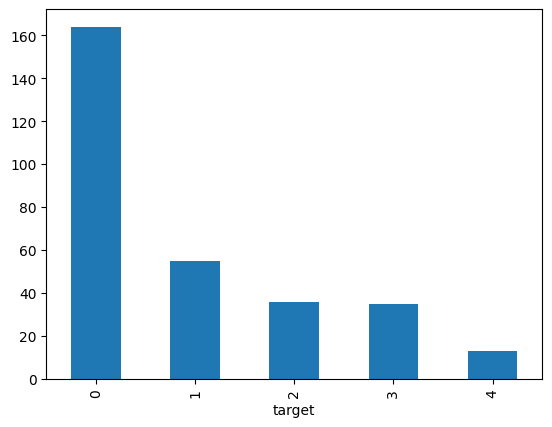

In [10]:
# Understanding our data
print(data.describe())
print(data.isnull().sum())
data['target'].value_counts().plot(kind='bar')

## Preprocess Steps
*   Replace '?' with NaN
*   Convert columns to numeric
*   Handle missing values
*   Scale features
*   One-hot encoding categorical variables
*   Drop original categorical columns and concatenate encoded columns
*   Ensure all column names are strings



In [13]:
data.replace('?', np.nan, inplace=True)
data = data.apply(pd.to_numeric, errors='coerce')

imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_imputed), columns=data_imputed.columns)

categorical_features = ['cp', 'restecg', 'slope', 'ca', 'thal']
encoder = OneHotEncoder()
encoded_data = pd.DataFrame(encoder.fit_transform(data_scaled[categorical_features]).toarray())

data_scaled = data_scaled.drop(categorical_features, axis=1)
data_scaled = pd.concat([data_scaled, encoded_data], axis=1)

data_scaled.columns = data_scaled.columns.astype(str)


## Clustering:
Appling hierarchial clustering, K-means and DBSCAN to the preprocessed dataset

In [21]:
kmeans = KMeans(n_clusters=3)
kmeans_labels = kmeans.fit_predict(data_scaled)

hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical_labels = hierarchical.fit_predict(data_scaled)

best_eps = None
best_min_samples = None
best_silhouette = -1
for eps in np.arange(0.1, 1.0, 0.1):
    for min_samples in range(2, 10):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(data_scaled)
        # Check if there are at least 2 clusters
        if len(set(dbscan_labels)) > 1:
            silhouette = silhouette_score(data_scaled, dbscan_labels)
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_eps = eps
                best_min_samples = min_samples

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan.fit_predict(data_scaled)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Visualization (PCA & t-SNE)
We'll use PCA and t-SNE to observe the clusters

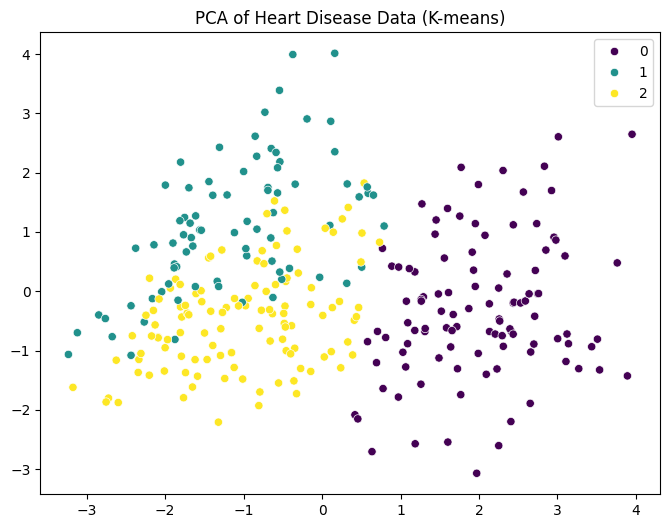

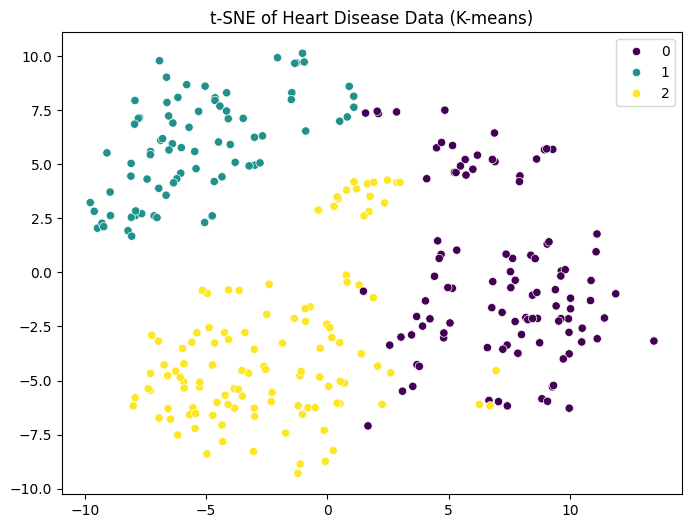

In [23]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=kmeans_labels, palette="viridis")
plt.title('PCA of Heart Disease Data (K-means)')
plt.show()

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(data_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=kmeans_labels, palette="viridis")
plt.title('t-SNE of Heart Disease Data (K-means)')
plt.show()


## Gaussian Mixture Models
Identifying risk factors and visulaizing the GMM clusters

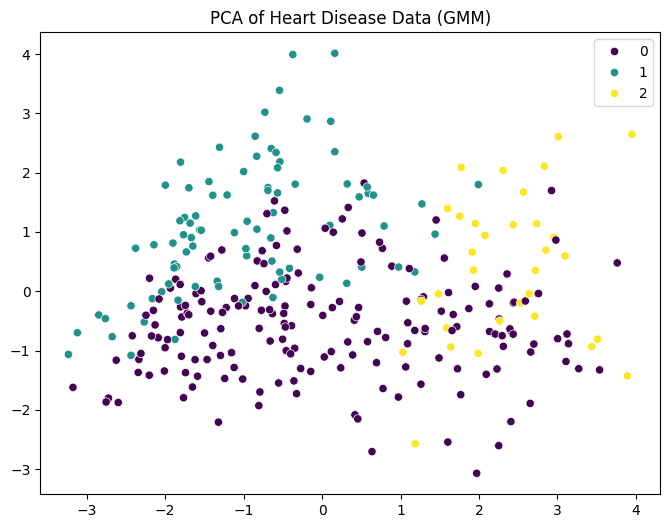

In [24]:
gmm = GaussianMixture(n_components=3)
gmm_labels = gmm.fit_predict(data_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=gmm_labels, palette="viridis")
plt.title('PCA of Heart Disease Data (GMM)')
plt.show()


# Evaluation
We'll use Silhoutte score and Davies-Bouldin index to evaluate the different clusters

In [25]:
kmeans_silhouette = silhouette_score(data_scaled, kmeans_labels)
kmeans_db = davies_bouldin_score(data_scaled, kmeans_labels)

hierarchical_silhouette = silhouette_score(data_scaled, hierarchical_labels)
hierarchical_db = davies_bouldin_score(data_scaled, hierarchical_labels)

dbscan_silhouette = silhouette_score(data_scaled, dbscan_labels)
dbscan_db = davies_bouldin_score(data_scaled, dbscan_labels)

gmm_silhouette = silhouette_score(data_scaled, gmm_labels)
gmm_db = davies_bouldin_score(data_scaled, gmm_labels)

# Compare performance
performance = pd.DataFrame({
    'Algorithm': ['K-means', 'Hierarchical', 'DBSCAN', 'GMM'],
    'Silhouette Score': [kmeans_silhouette, hierarchical_silhouette, dbscan_silhouette, gmm_silhouette],
    'Davies-Bouldin Index': [kmeans_db, hierarchical_db, dbscan_db, gmm_db]
})

print(performance)

      Algorithm  Silhouette Score  Davies-Bouldin Index
0       K-means          0.135065              2.163452
1  Hierarchical          0.181853              1.907346
2        DBSCAN         -0.056193              1.175540
3           GMM          0.089390              2.409797


# Compare Performances

* **Hierarchical Clustering** has the highest Silhouette Score (0.181853), which shows it is the best-defined clusters

* **DBSCAN** has the lowest Davies-Bouldin Index (1.175540), suggesting good cluster quality but weaker with cluster definition

* **K-means** and **GMM** are less effective in defining clusters and maintaining cluster quality compared to Hierarchical Clustering and DBSCAN.

Therefore, Hierarchical Clustering is a stronger choice which proves to be the best balance between cluster definition and quality for this dataset.